In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [53]:
df = pd.read_csv('Bot_lane.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [54]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
0,99,6,0,24,6,1,15582,4590,2697,7712,10457,14,8,60,57
1,15,9,1,10,8,2,17915,17862,9714,12337,12963,14,2,23,0
2,498,3,5,5,2,1,11968,5871,2456,15877,8925,11,2,27,6
3,25,0,7,10,0,0,11120,1821,1201,19085,8150,13,11,57,43
4,350,3,2,28,2,1,14093,9959,1260,8601,9166,13,8,51,30


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [55]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [56]:
lane = lane.groupby("Champion").mean()

In [57]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
1,5.588235,7.117647,10.000000,2.352941,1.235294,15315.882353,4065.882353,2301.705882,16097.000000,10354.529412,13.588235,2.117647,32.588235,26.058824
3,2.177885,6.408654,12.389423,0.716346,0.894231,8020.052885,2172.423077,1114.870192,20357.475962,7795.259615,12.326923,7.514423,49.500000,33.567308
4,4.695652,6.521739,8.000000,2.130435,1.347826,13985.956522,6869.347826,3051.608696,19792.217391,10955.043478,13.347826,2.608696,25.695652,34.521739
7,4.833333,5.666667,7.500000,2.166667,1.000000,13342.666667,3118.333333,1634.500000,15626.333333,9073.666667,13.000000,2.000000,23.500000,12.500000
8,5.692308,6.000000,7.653846,2.538462,1.346154,21710.961538,5564.769231,3017.500000,30573.615385,11530.615385,14.230769,2.500000,19.692308,4.000000


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

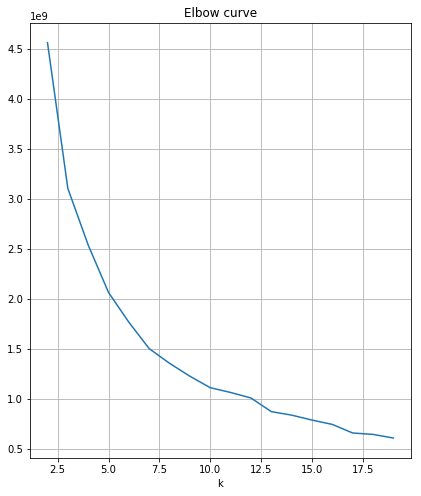

In [58]:
distorsions = []

for k in range(2,20):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(2, 20), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [59]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

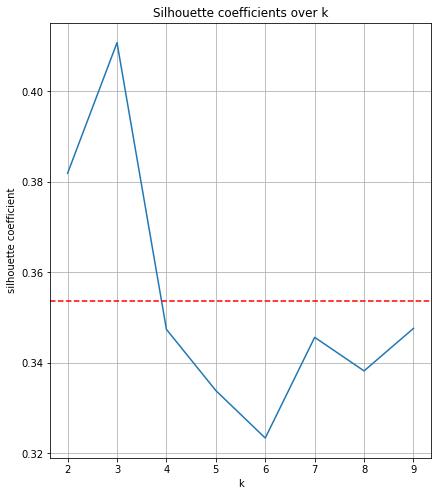

In [60]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 4 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [61]:
k_means = KMeans(n_clusters = 3).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [62]:
cluster_assignments

array([1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2,
       1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 2,
       0, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 1,
       0, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 0,
       1, 2, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1],
      dtype=int32)

In [63]:
clustered = lane.groupby('Champion').mean()

In [64]:
clustered['Cluster'] = cluster_assignments

In [65]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    20
1    45
2    45
Name: Kills, dtype: int64

There are 46 champions in Cluster 0, 46 champions in cluster 1, ONLY 1 champion in cluster 2, and 25 champions in cluster 3. 

In [66]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,5.449546,7.143863,8.518013,2.303947,1.340693,15475.995956,6467.108287,2632.797258,27370.298024,10568.115626,13.763595,2.850406,28.073239,22.971796
1,3.026259,5.800085,11.784558,1.320412,1.034408,9827.988897,3023.530248,1538.897774,16981.920903,8464.123947,12.597990,5.326441,44.923627,29.031232
2,6.094312,5.948376,8.090618,2.845589,1.462703,19248.017706,9106.624053,3803.998449,17695.719144,11554.591404,13.833470,2.384390,25.153946,18.342634


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [67]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [71]:
clustered[clustered['Cluster'] == 2]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
4,4.695652,6.521739,8.000000,2.130435,1.347826,13985.956522,6869.347826,3051.608696,19792.217391,10955.043478,13.347826,2.608696,25.695652,34.521739,2,TwistedFate
13,4.903226,6.032258,6.354839,2.129032,1.354839,18317.967742,8638.451613,2319.483871,19689.354839,10530.419355,13.451613,2.387097,17.548387,18.000000,2,Ryze
15,5.732611,4.927947,8.327780,2.997085,1.525614,18686.503540,10992.054144,4626.200750,15940.126614,12351.852978,14.061224,2.175760,21.515618,1.449813,2,Sivir
17,6.047619,7.555556,8.444444,2.412698,1.285714,22293.841270,4613.809524,2255.000000,17817.047619,10058.619048,12.904762,3.269841,41.857143,37.825397,2,Teemo
18,7.565445,5.183246,6.553665,3.696335,1.721204,17886.476440,13380.041885,6310.732984,17559.570681,12538.840314,13.893979,1.543194,20.659686,5.624346,2,Tristana
21,6.726277,5.558394,8.032847,3.076642,1.562044,19751.080292,10398.773723,5308.868613,16953.985401,11895.478102,13.770073,1.682482,21.700730,7.496350,2,MissFortune
22,5.237226,5.757299,9.848540,2.481752,1.421533,18174.562044,10284.669708,4184.076642,16548.757299,11494.928832,13.859489,1.959854,24.854015,42.250000,2,Ashe
29,8.254386,5.881579,8.043860,3.877193,1.750000,20929.741228,10022.271930,3946.780702,18661.697368,12332.144737,13.934211,1.359649,18.706140,14.750000,2,Twitch
30,6.627451,8.843137,10.098039,2.196078,1.509804,26336.980392,7661.392157,1982.882353,19609.196078,11748.176471,14.098039,1.137255,15.294118,18.000000,2,Karthus


# 